In [1]:
# adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

import pandas as pd

df_reg_ot = pd.read_parquet("../data/regular_ot_pbp.parquet")
df_reg_ot.drop("time_remaining", axis=1, inplace=True)
df_ply_ot = pd.read_parquet("../data/playoff_ot_pbp.parquet")
df_ply_ot.drop("seconds_elapsed", axis=1, inplace=True)

df = pd.concat([df_reg_ot, df_ply_ot])

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sliding_window

window_size = 3

df = sliding_window.plays_preceding_goals(df, window_size)

one_hot = pd.get_dummies(df, columns=["event", "team", "event_zone", "home_zone", "strength"])
grouped = one_hot.groupby(["season", "game"])

# create sliding window within each game
X, y = sliding_window.sliding_window_on_groups(grouped, window_size)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, train_size=0.8, random_state=42
)

100%|██████████| 2900/2900 [00:02<00:00, 1215.74it/s]


In [16]:
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Input
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential([
    Input(shape=(window_size, X.shape[2])),
    LSTM(16),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005, clipvalue=1.0))

history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - loss: 0.6965 - val_loss: 0.6921
Epoch 2/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - loss: 0.6930 - val_loss: 0.6932
Epoch 3/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - loss: 0.6934 - val_loss: 0.6917
Epoch 4/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - loss: 0.6936 - val_loss: 0.6916
Epoch 5/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 0.6922 - val_loss: 0.6928
Epoch 6/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - loss: 0.6927 - val_loss: 0.6910
Epoch 7/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - loss: 0.6915 - val_loss: 0.6914
Epoch 8/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - loss: 0.6907 - val_loss: 0.6906
Epoch 9/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.6912 - val_loss: 0.6944
Epoch 10/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - loss: 0.6933 - val_loss: 0.6931
Epoch 11/200
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.6927 - val_loss: 0.69

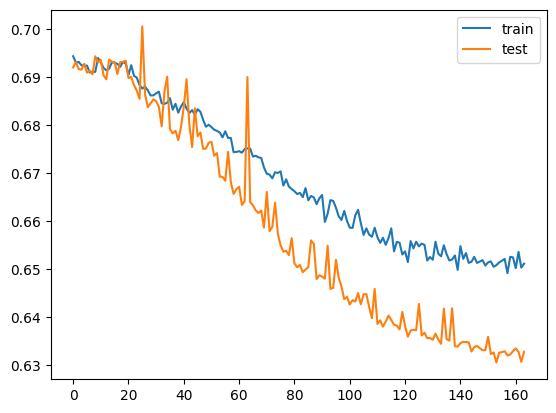

In [17]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
# adapted from https://stackoverflow.com/a/58598737
# given that the end goal is win probability over time and not predicting the victor,
# this is not a fair measure of the model
# especially difficult with overtime

from sklearn.metrics import confusion_matrix
from numpy import round

predictions = model.predict(X_test)
y_pred = round(predictions)

cm = confusion_matrix(y_test, y_pred)

total = sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : %.6f' % accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : %.6f' % sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : %.6f' % specificity)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy : 0.680311
Sensitivity : 0.671378
Specificity : 0.689218


In [19]:
model.save("models/meter_ot_lstm16.keras")